In [1]:
# If you are using Anconda, please re-download this file to current directory:
# https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/course-env.yml
# Then, run this cell
# !conda env update --file course-env.yml

<a href="https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/module-02-00_Linear-Modeling.ipynb" target="_blank">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Linear Modeling

This tutorial was inspired by and adapted from the [Neuromatch Academy tutorials](https://github.com/NeuromatchAcademy/course-content) [[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)].

## Goals of this tutorial
1. [Specifying a simple linear model](#What-is-a-linear-model?)
2. [Simulating a linear model](#Model-simulations)
3. [Gain an understanding about parameters (e.g., intercept, slope) in a linear model](#Model-fitting)

## What is a linear model?

In its most basic form, a linear model can be written like this (e.g., a simple linear regression):

$$
y_n = intercept + b*x_n + \epsilon_n
$$

where `y` is the **dependent (outcome) variable** and `x` is an **independent (explanatory/manipulated) variable**---these variables represent data (each participant `n` has an observation at `x`,`y`). 

`y` is a function of `x` and determined by 2 components:
- a non-random component: $intercept + \beta*x_n$
- random component: $\epsilon_n$

The `intercept` is the value of `y` when `x=0`. `beta` is a weighted paramter that determined the slope of the fitted linear model. These parameters are fixed quanities that we will detemined by fitting a linear model.

The `error` describes the random component of the linear relationship between `x` and `y`---this is the difference between the true values (`y`) and the predicted values (`y_hat`). We can re-arrange this equation:

$$
y_n = (intercept + \beta*x_n) + \epsilon_n
$$
$$
y_n = \hat{y_n} + \epsilon_n
$$
$$
\epsilon_n = y_n - \hat{y_n}
$$



In [2]:
# let's begin by importing packages
import pandas as pd, numpy as np, requests
from scipy.stats import truncnorm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline

## Model Simulations
Simulations are great ways to test models. By creating a simple synthetic dataset, we will know the true underlying model which allows us to see how our estimation efforts compare in uncovering the real model.

Below, we will simulate a linear relationship between two variables `x` (antisocial behavior) and `y` (distance kept from others during the COVID-19 pandemic), and then we will add some "noise" to those data. This will help us gain a better understanding about expected results from [O'Connell, K., Berluti, K., Rhoads, S. A., & Marsh, A. A. (2021). Reduced social distancing during the COVID-19 pandemic is associated with antisocial behaviors in an online United States sample. PLoS ONE.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244974).

In [3]:
# setting a fixed seed to our random number generator 
# ensures we will always
# get the same psuedorandom number sequence
np.random.seed(2021)

# Let's set some parameters
beta = -1.75
n_subjects = 131

# Draw x
intercept = 347
x0 = np.ones((n_subjects, 1))

lower, upper = 32, 139 # range of STAB scores 
mu, sigma = 54.9, 30.1 # mean, and st dev
x1 = truncnorm.rvs((lower-mu)/sigma,
                   (upper-mu)/sigma,
                   loc=mu,
                   scale=sigma,
                   size=(n_subjects,1))

X = np.hstack((x0, x1))

# sample from a standard normal distribution
noise = np.random.normal(2, 10, (n_subjects,1)) 

# calculate y
y = intercept + beta * x1 + noise

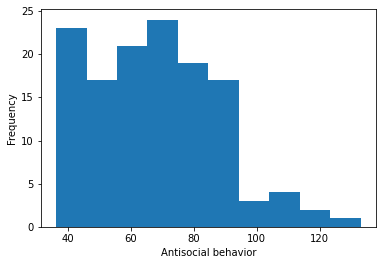

In [4]:
# Plot a histogram
fig, ax = plt.subplots()

ax.hist(x1)
ax.set(xlabel='Antisocial behavior', ylabel='Frequency')
plt.show()

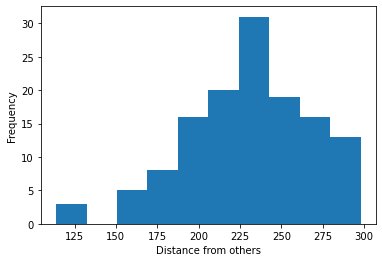

In [5]:
# Plot a histogram
fig, ax = plt.subplots()

ax.hist(y)
ax.set(xlabel='Distance from others', ylabel='Frequency')
plt.show()

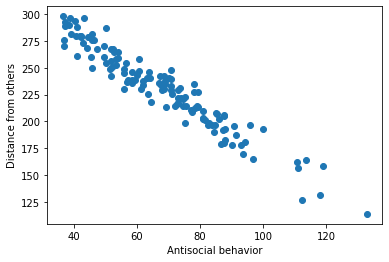

In [6]:
# Plot the results
fig, ax = plt.subplots()
ax.scatter(x1, y)  # produces a scatter plot
ax.set(xlabel='Antisocial behavior', ylabel='Distance from others')
plt.show()

Now that we have our noisy dataset, we can try to estimate the underlying model that produced it. We use MSE to evaluate how successful a particular slope estimate $\hat{\beta}$ is for explaining the data, with the closer to 0 the MSE is, the better our estimate fits the data.

<hr>

## Model Fitting

Now, we will fit our simulated data to a simple linear regression, using least-squares optimization. 

**Linear least squares** is a great optimization procedure that we are going to use for data fitting. 

Let's recall our simple linear model above. Suppose you have a set of measurements, $y_{n}$ (the "dependent" variable) obtained for different input values, $x_{n}$ (the "independent" or "explanatory" variable). Suppose we believe the measurements are proportional to the input values, but are corrupted by some (random) measurement errors, $\epsilon_{n}$, that is:

$$\hat{y_{n}}= \beta_0 + \beta_1 x_{n}+\epsilon_{n}$$

for some unknown slope parameter $\beta.$ The least squares regression problem uses **mean squared error (MSE)** as its objective function, it aims to find the value of the parameter $\beta$ by minimizing the average of squared errors:

$$
\min _{\beta} \frac{1}{N}\sum_{n=1}^{N}\left(y_{n}-\hat{y_{n}}\right)^{2}
$$

We will now explore how MSE is used in fitting a linear regression model to data. 

### Computing MSE

In this exercise you will implement a method to compute the mean squared error for a set of inputs $x$, measurements $y$, and slope estimate $\hat{\beta}$. We will then compute and print the mean squared error for 3 different choices of beta.

In [7]:
def mse(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    intercept (float): The estimate of the intercept parameter
    beta_hat (float): The estimate of the slope parameter

    Returns:
    float: The estimated y_hat computed from X and the estimated parameter(s).
    float: The mean squared error of the data with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return y_hat, mse

In [8]:
intercept = 347
possible_betas = [-0.75, -1.75, -2.75]

for beta_hat in possible_betas:
        
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)
    print(f"beta_hat of {beta_hat} has an MSE of {MSE_val:.2f}")

beta_hat of -0.75 has an MSE of 4827.76
beta_hat of -1.75 has an MSE of 111.37
beta_hat of -2.75 has an MSE of 5438.72


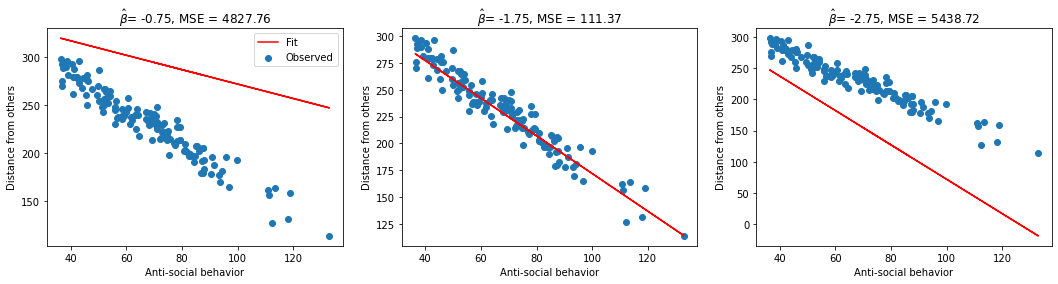

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))

for beta_hat, ax in zip(possible_betas, axes):

    # True data
    ax.scatter(x1, y, label='Observed')  # our data scatter plot

    # Compute and plot predictions
    y_hat, MSE_val = mse([intercept, beta_hat], X, y)

    ax.plot(x1, y_hat, color='r', label='Fit')  # our estimated model

    ax.set(
        title= fr'$\hat{{\beta}}$= {beta_hat}, MSE = {MSE_val:.2f}',
        xlabel='Anti-social behavior',
        ylabel='Distance from others')
    
axes[0].legend()
plt.show()

<hr>

### Model parameters
Using an interactive widget, we can easily see how changing our slope estimate changes our model fit. We display the **residuals**, the differences between observed and predicted data, as line segments between the data point (observed response) and the corresponding predicted response on the model fit line.

<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.css" integrity="sha512-5A8nwdMOWrSz20fDsjczgUidUBR8liPYU+WymTZP1lmY9G6Oc7HlZv156XqnsgNUzTyMefFTcsFH/tnJE/+xBg==" crossorigin="anonymous" />

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js"></script>

<script type="text/x-thebe-config">
     {
       requestKernel: true,
       binderOptions: {
         repo: "matplotlib/ipympl",
         ref: "0.6.1",
         repoProvider: "github",
       },
     }
</script>
<script src="https://unpkg.com/thebe@latest/lib/index.js"></script>
   
<button id="activateButton" style="width: 450px; height: 40px; font-size: 1.5em;">
     Click here to interact with this visualization
</button>

<script>
var bootstrapThebe = function() {
   thebelab.bootstrap();
}
document.querySelector("#activateButton").addEventListener('click', bootstrapThebe)
</script>

<pre data-executable="true" data-language="python">

In [10]:
# interactive display
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def plot_observed_vs_predicted(beta_hats, X, y):
    """ Plot observed vs predicted data

    Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    beta_hats (ndarray): An array of shape (betas,) that contains the estimate of the slope parameter(s)

    """
    y_hat, MSE_val = mse(beta_hats, X, y)
    
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y, label='Observed')  # our data scatter plot
    ax.plot(X[:,1], y_hat, color='r', label='Fit')  # our estimated model

    # plot residuals
    ymin = np.minimum(y, y_hat)
    ymax = np.maximum(y, y_hat)
    ax.vlines(X[:,1], ymin, ymax, 'g', alpha=0.5, label='Residuals')

    ax.set(
        title=fr"$intercept={beta_hats[0]:0.2f}, \hat{{\beta}}$ = {beta_hats[1]:0.2f}, MSE = {MSE_val:.2f}",
        xlabel='x',
        ylabel='y')
    
    ax.legend()
    plt.show()

# %config InlineBackend.figure_format = 'retina'

@widgets.interact(beta_hat=widgets.FloatSlider(-1.75, min=-3, max=0),
                  intercept=widgets.FloatSlider(intercept, min=100, max=400))

def plot_data_estimate(intercept, beta_hat):
    plot_observed_vs_predicted([intercept, beta_hat], X, y)

ModuleNotFoundError: No module named 'ipympl'

</pre>
<hr>

### Least-squares minimization

While the approach detailed above (computing MSE at various values of $\hat\beta$) quickly got us to a good estimate, it still relied on us guessing which beta values to select. If we didn't pick good guesses to begin with, we might miss the best possible parameter values.

Thus, there must be a better way "guess-timate" them, right?

Why don't we try an **exhaustive search** of across a specified range of parameter values?

In [ ]:
# Exhaustive search 
param_b0 = np.arange(300, 450, .5)
param_b1 = np.arange(-3, 0, .05)

first_run = 'first'
mse_out = []
for b0 in param_b0:
    for b1 in param_b1:
        if first_run is not None:
            first_run = None
            Params = [b0, b1]
        else:
            Params = np.vstack((Params, [b0, b1]))
        mse_out = np.append(mse_out, mse([b0, b1], X, y)[1])

In [ ]:
# From out exhaustive search:
# let's see if we can recover the index with the smallest MSE
min_index = np.argmin(mse_out)

print(f'b0, b1 = {Params[min_index]}, MSE = {mse_out[min_index]:.2f}')

We see that our fit is $b_0 = 353$ and $b_1 = -1.8$, which is quite close to our original!

**We can also 3D plot our search!**

In [ ]:
b0_grid = np.reshape(np.reshape(Params[:,0],(len(Params),1)),
                     (int(len(Params)/100), 100))
b1_grid = np.reshape(np.reshape(Params[:,1],(len(Params),1)), 
                     (int(len(Params)/100), 100))
mse_grid = np.reshape(np.reshape(mse_out,(len(mse_out),1)), 
                      (int(len(mse_out)/100), 100))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(b1_grid, b0_grid, mse_grid,
                rstride=1, cstride=1,
                cmap="coolwarm_r",
                linewidth=0, 
                antialiased=False,
                alpha=.6,
                edgecolor='none')

ax.set_xlabel('b1')
ax.set_ylabel('b0')
ax.set_zlabel('MSE')
ax.set_zlim(0, np.max(mse_grid))

plt.show()

<hr>

### scipy.optimize.minimize

But, writing an exhaustive search by hand is prone to errors, too! It depends largely on the specified parameters for the search (i.e., we only sampled 300 to 450 in increments of .5 above for $b_0$).

It can also be very time-consuming and computationally-expensive.

Instead, we can utilize minimization algorithms that we optimized to solve minimization problems like this. Let's use the `scipy.optimize.minimize` function, which takes in the following inputs:
- a cost function to minimize (`mse()` in our case)
- starting points for the parameters to estimate (starting points for `b0` and `b1` in our case)
- other arguments that need to be input into our objective function (`X` and `y` in our case)

It will return an `OptimizeResult` object containing the estimated parameters (along with the value of minimized MSE)

In [ ]:
def mse_to_minimize(beta_hats, X, y):
    """Compute the mean squared error

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    intercept (float): The estimate of the intercept parameter
    beta_hat (float): The estimate of the slope parameter

    Returns:
    float: The mean squared error of the data with the estimated parameter(s).
    """
    
    assert len(beta_hats) == np.shape(X)[1]
    
    # Compute the estimated y
    y_hat = 0
    for index, b in enumerate(beta_hats):
        y_hat += b*X[:,index]
    
    y_hat = y_hat.reshape(len(y_hat),1)
    
    # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return mse

In [ ]:
# minimize MSE using scipy.optimize.minimize
res = minimize(mse_to_minimize, # objective function
               (350, -1.75), # estimated starting points
               args=(X, y)) # arguments

print(f'b0, b1 = {(res.x)}, MSE = {res.fun}')
plot_observed_vs_predicted([res.x[0], res.x[1]], X, y)

We see that we can get a better fit: $b_0 = 352.01$ and $b_1 = -1.79$, which fairly accurate! Note that our **MSE** value is also smaller than last time!

<hr>

### Analytic solution for Least Squares Optimization (Bonus)

While the approach detailed above (computing MSE at various values of $\hat\beta$) got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn't pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let's go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let's solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus. Please see appendix below for this derivation! After computing the minimum, we find that:

$$
\hat\beta = \frac{\vec{x}^\top \vec{y}}{\vec{x}^\top \vec{x}}
$$

This is known as solving the normal equations. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.

In [ ]:
def ordinary_least_squares(X, y):
    """Ordinary least squares estimator for linear regression.

    Args:
    X (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

    Returns:
    ndarray: estimated parameter values of shape (n_regressors)
    """

    # Compute theta_hat using OLS
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

    return beta_hat

In [ ]:
# Compute beta_hat
beta_hat2 = ordinary_least_squares(X, y)
print(f"b0={beta_hat2[0]}, b1={beta_hat2[1]}")

# Compute MSE
y_hat2 = X @ beta_hat2
print(f"MSE = {np.mean((y - y_hat2)**2):.2f}")

### Simulated versus fitted data

In addition to reviewing the residuals, we can also look at the simulated data (`y`) versus fitted data (`y_hat`). This is more common to evaluate how well your model recovered your parameters because we often dealing with more than one dimension.

In [ ]:
# correlate y and y_hat
corrcoef = np.corrcoef(y.flatten(),y_hat2.flatten())[0,1]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(y, y_hat2)  # produces a scatter plot
ax.set(xlabel='y (simulated data + noise)', ylabel=fr'$\haty$ (fitted data)')
plt.title((f'r={corrcoef:.2f}'))
plt.show()

Awesome! Looks pretty nice!

<hr>

### Comparison to a statistics package
Okay, cool!

Let's see how our manual linear model fitting compares to a typical statistical packages. Let's import `scipy.stats` and run a simple linear regression with our observed data!

In [ ]:
from scipy import stats
stat_res = stats.linregress(X[:,1],y[:,0])

y_hat_new = (stat_res.intercept + stat_res.slope*X[:,1]).reshape((len(y),1))

print(f'b1 = {stat_res.slope:.2f} , b0 = {stat_res.intercept:.2f}, MSE = {np.mean((y - y_hat_new)**2):.2f}')

<hr>

### Multivariate data
Now that we have considered the univariate case, we turn to the general linear model case, where we can have more than one regressor, or feature, in our input.

Recall that our original univariate linear model was given as

$$
y = \beta x + \epsilon
$$

where $\beta$ is the slope and $\epsilon$ some noise. We can easily extend this to the multivariate scenario by adding another parameter for each additional feature

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... +\beta_d x_d + \epsilon
$$

where $\beta_0$ is the intercept and $d$ is the number of features (it is also the dimensionality of our input).

For now, we will focus on the two-dimensional case ($d=2$), which allows us to easily visualize our results. 

In this case our model can be writen as:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon
$$

In [ ]:
# Let's add age
np.random.seed(2021)

b1 = -1.84
b2 = -.68

lower2, upper2 = 21, 65 # range of ages
mu2, sigma2 = 36.34, 10.08 # mean and st dev
x2 = np.random.normal(mu2, sigma2,
                      size=(n_subjects,1))

X_a = np.hstack((x0, x1, x2))

# sample from a standard normal distribution
noise = np.random.normal(2, 10, (n_subjects,1)) 

y_a = (b0 + b1*x1 + b2*x2 + noise).reshape((n_subjects,1))

In [ ]:
# Compute beta_hat
beta_hat3 = ordinary_least_squares(X_a, y_a)
print(f"b0={beta_hat3[0]}, b1={beta_hat3[1]}, b2={beta_hat3[2]}")

# Compute MSE
y_hat3 = (X_a @ beta_hat3)
print(f"MSE = {np.mean((y_a - y_hat3)**2):.2f}")

### Summary
- Linear least squares regression is an optimization procedure that can be used for data fitting:
    - Task: predict a value for $y$ given $x$
    - Procedure: minimize $\textrm{MSE}$
- **Key point**: We fit the model by defining an *objective function* and minimizing it. 

- **Note**: In this case, there is also an *analytical* solution to the minimization problem. But as models become more-complex, we will need to use a minimization algorithm to help us out!

<hr>

## Appendix: Least-squares derivation
Here's the derivation of the least squares solution.

We first set the derivative of the error expression with respect to $\theta$ equal to zero, 

$$
\frac{d}{d\beta}\frac{1}{N}\sum_{i=1}^N(y_i - \beta x_i)^2 = 0 \\
\frac{1}{N}\sum_{i=1}^N-2x_i(y_i - \beta x_i) = 0
$$

where we used the chain rule. Now solving for $\theta$, we obtain an optimal value of:

$$
\hat\beta = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
$$

Which we can write in vector notation as:

$$
\hat\beta = \frac{\vec{x}^\top \vec{y}}{\vec{x}^\top \vec{x}}
$$


This is known as solving the *normal equations*. For different ways of obtaining the solution, see the notes on [Least Squares Optimization](https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf) by Eero Simoncelli.